In [1]:
import random
import torch
torch.cuda.set_device(0)
import cv2
import numpy as np
from run_infinity import *
import sys, torch, os
print("python:", sys.executable)
print("cwd:", os.getcwd())
print("torch version:", torch.__version__)
print("cuda:", torch.version.cuda, "is_available:", torch.cuda.is_available())
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


model_path='/root/autodl-tmp/Predata/infinity_2b_reg.pth'
vae_path='/root/autodl-tmp/Predata/infinity_vae_d32reg.pth'
text_encoder_ckpt = '/root/autodl-tmp/Predata/flan-t5-xl'
args=argparse.Namespace(
    pn='1M',
    model_path=model_path,
    cfg_insertion_layer=0,
    vae_type=32,
    vae_path=vae_path,
    add_lvl_embeding_only_first_block=1,
    use_bit_label=1,
    model_type='infinity_2b',
    rope2d_each_sa_layer=1,
    rope2d_normalized_by_hw=2,
    use_scale_schedule_embedding=0,
    sampling_per_bits=1,
    text_encoder_ckpt=text_encoder_ckpt,
    text_channels=2048,
    apply_spatial_patchify=0,
    h_div_w_template=1.000,
    use_flex_attn=0,
    cache_dir='/dev/shm',
    checkpoint_type='torch',
    seed=0,
    bf16=1,
    save_file='tmp.jpg',
    customized_flash_attn=False,
    sparsity_ratio_sa=0.6,
    sparsity_ratio_ca=None,
)

/root/miniconda3/envs/infinity/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/infinity/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/root/miniconda3/envs/infinity/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribu

python: /root/miniconda3/envs/infinity/bin/python
cwd: /root/autodl-tmp/Infinity_sparse/tools
torch version: 2.9.0+cu126
cuda: 12.6 is_available: True


In [2]:
for k, v in {
    "enable_model_cache": True,   # 本次报错的关键字段
}.items():
    if not hasattr(args, k):
        setattr(args, k, v)

# load text encoder
text_tokenizer, text_encoder = load_tokenizer(t5_path=args.text_encoder_ckpt)
# load vae
vae = load_visual_tokenizer(args)
# load infinity
infinity = load_transformer(vae, args)

print(infinity)

`torch_dtype` is deprecated! Use `dtype` instead!


[Loading tokenizer and text encoder]


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


model_path: /root/autodl-tmp/Predata/infinity_2b_reg.pth, slim_model_path: /root/autodl-tmp/Predata/infinity_2b_reg.pth
local_model_path: /dev/shm/tmp/_root_autodl-tmp_Predata_infinity_2b_reg.pth, local_slim_model_path: /dev/shm/tmp/_root_autodl-tmp_Predata_infinity_2b_reg.pth
load checkpoint from /dev/shm/tmp/_root_autodl-tmp_Predata_infinity_2b_reg.pth
[Loading Infinity]
self.codebook_dim: 32, self.add_lvl_embeding_only_first_block: 1,             self.use_bit_label: 1, self.rope2d_each_sa_layer: 1, self.rope2d_normalized_by_hw: 2
self.num_blocks_in_a_chunk=4, depth=32, block_chunks=8

[constructor]  ==== customized_flash_attn=False (using_flash=0/32), fused_mlp=False (fused_mlp=0/32) ==== 
    [Infinity config ] embed_dim=2048, num_heads=16, depth=32, mlp_ratio=4, swiglu=False num_blocks_in_a_chunk=4
    [drop ratios] drop_rate=0.0, drop_path_rate=0.1 (tensor([0.0000, 0.0032, 0.0065, 0.0097, 0.0129, 0.0161, 0.0194, 0.0226, 0.0258,
        0.0290, 0.0323, 0.0355, 0.0387, 0.0419, 0.04

In [4]:
prompt = """A beautiful Chinese woman with graceful features, close-up portrait, long flowing black hair, wearing a traditional silk cheongsam delicately embroidered with floral patterns, face softly illuminated by ambient light, serene expression"""
cfg = 3
tau = 0.5
h_div_w = 1/1 # aspect ratio, height:width
seed = random.randint(0, 10000)
enable_positive_prompt=0

h_div_w_template_ = h_div_w_templates[np.argmin(np.abs(h_div_w_templates-h_div_w))]
scale_schedule = dynamic_resolution_h_w[h_div_w_template_][args.pn]['scales']
scale_schedule = [(1, h, w) for (_, h, w) in scale_schedule]
generated_image = gen_one_img(
    infinity,
    vae,
    text_tokenizer,
    text_encoder,
    prompt,
    g_seed=seed,
    gt_leak=0,
    gt_ls_Bl=None,
    cfg_list=cfg,
    tau_list=tau,
    scale_schedule=scale_schedule,
    cfg_insertion_layer=[args.cfg_insertion_layer],
    vae_type=args.vae_type,
    sampling_per_bits=args.sampling_per_bits,
    enable_positive_prompt=enable_positive_prompt,
    save_sparsity_masks=False,
    sparsity_mask_save_path='./sparsity_masks/mask_data.pkl'
)
args.save_file = 'ipynb_tmp.jpg'
os.makedirs(osp.dirname(osp.abspath(args.save_file)), exist_ok=True)
cv2.imwrite(args.save_file, generated_image.cpu().numpy())
print(f'Save to {osp.abspath(args.save_file)}')

prompt=A beautiful Chinese woman with graceful features, close-up portrait, long flowing black hair, wearing a traditional silk cheongsam delicately embroidered with floral patterns, face softly illuminated by ambient light, serene expression
cfg: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], tau: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
cost: 32.312273025512695, infinity cost=32.28408360481262
Save to /root/autodl-tmp/Infinity_sparse/tools/ipynb_tmp.jpg


成功加载数据: ./sparsity_masks/mask_data.pkl
总stage数: 416
总block数: 416
SPARSITY MASK 综合分析报告

1. 基本统计分析
----------------------------------------
总mask数量: 416
平均稀疏度: 0.5548 ± 0.1604
稀疏度范围: [0.0000, 0.6168]

按attention类型统计:
  self_attention: 416个mask, 平均稀疏度: 0.5548

2. 保存详细数据到CSV
----------------------------------------
详细数据已保存到: ./sparsity_analysis/sparsity_details.csv

3. 生成可视化图表
----------------------------------------
保存趋势图到: ./sparsity_analysis/sparsity_trend.png


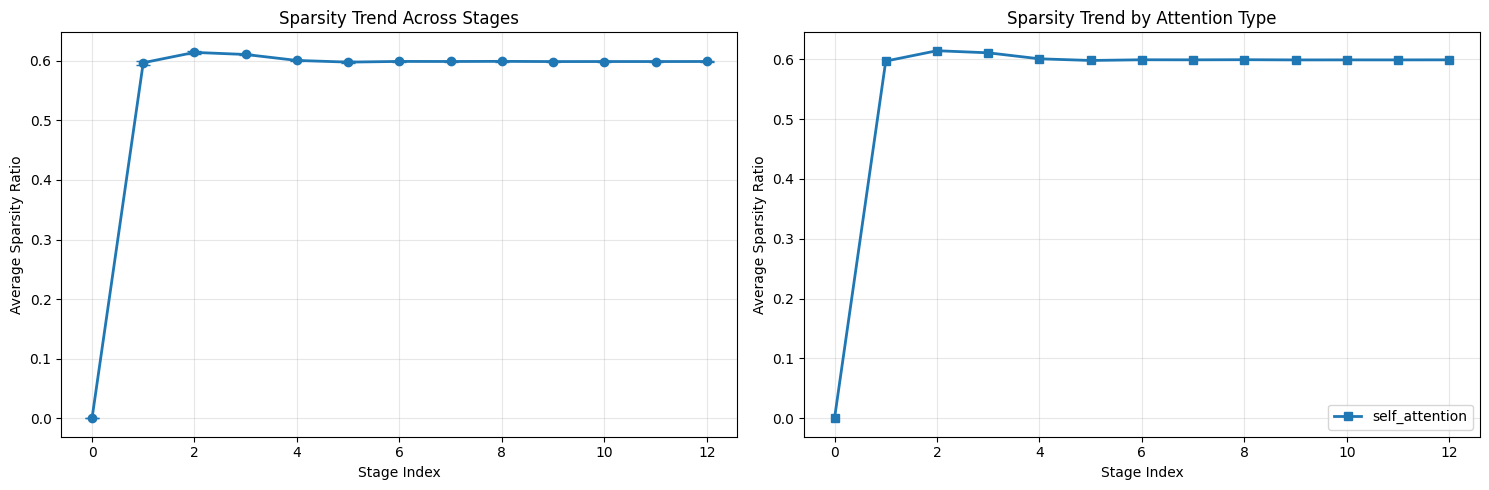

趋势图已保存到: ./sparsity_analysis/sparsity_trend.png
保存图像到: ./sparsity_analysis/stage_1_block_0_head_sparsity.png


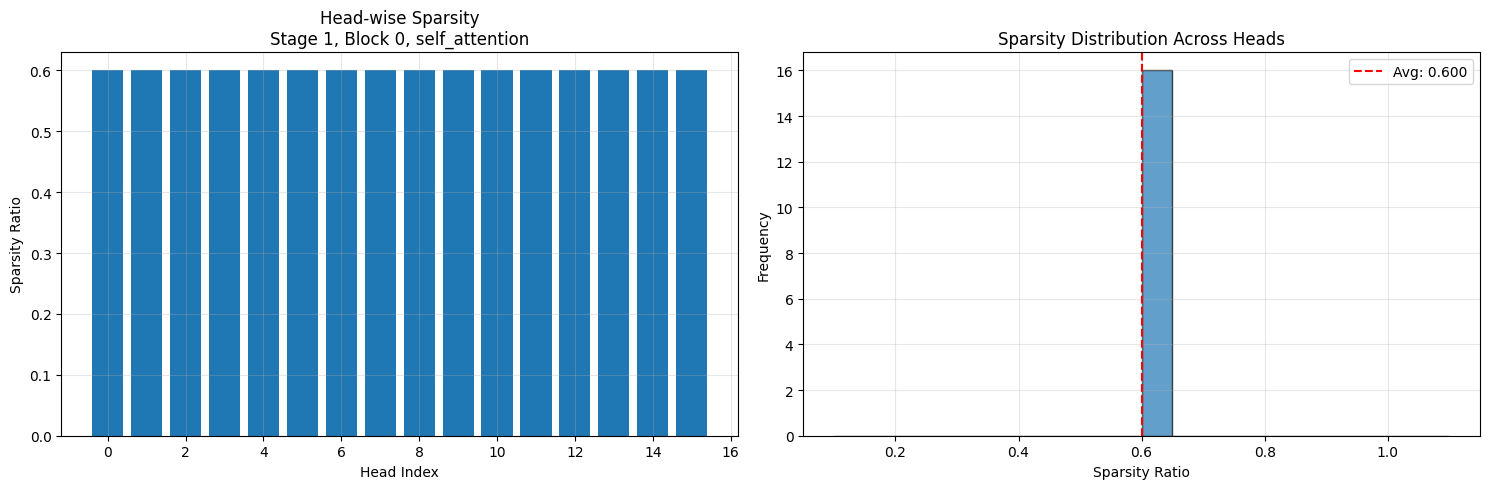

Head-wise稀疏度分析图已保存到: ./sparsity_analysis/stage_1_block_0_head_sparsity.png
保存热力图到: ./sparsity_analysis/stage_1_block_0_heatmap.png


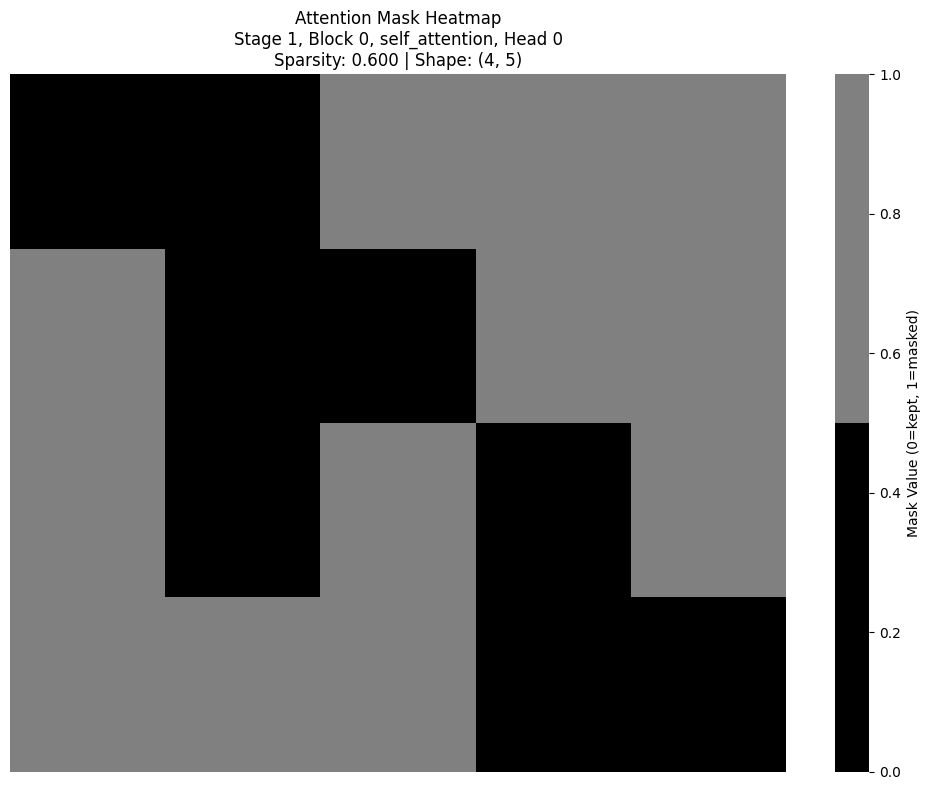

Mask热力图已保存到: ./sparsity_analysis/stage_1_block_0_heatmap.png
保存图像到: ./sparsity_analysis/stage_2_block_0_head_sparsity.png


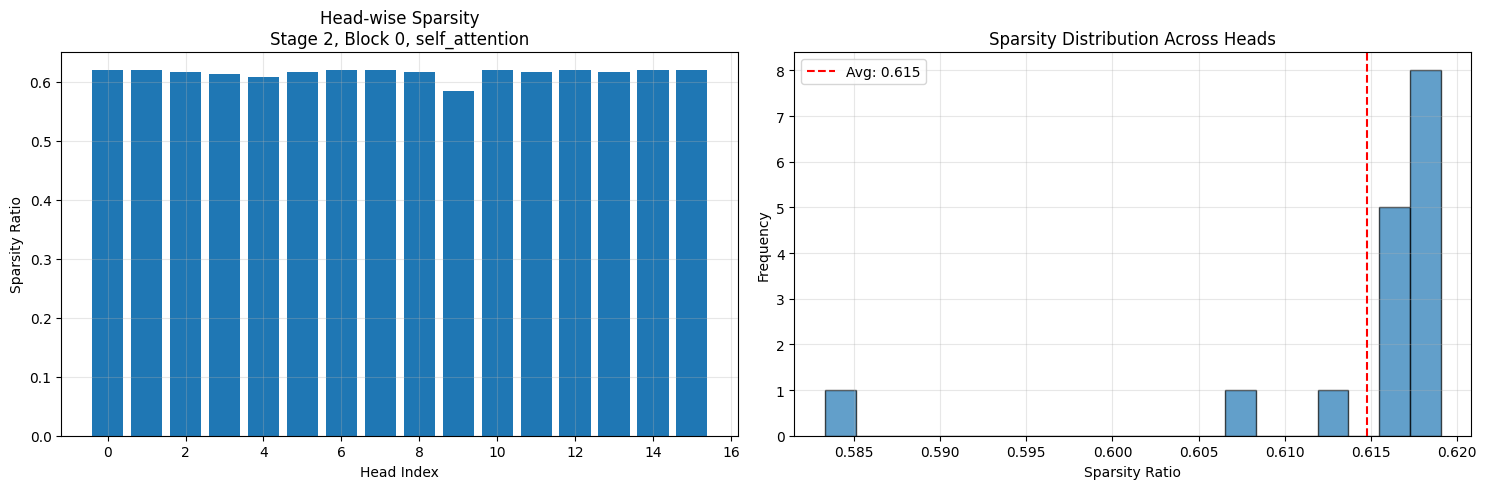

Head-wise稀疏度分析图已保存到: ./sparsity_analysis/stage_2_block_0_head_sparsity.png
保存热力图到: ./sparsity_analysis/stage_2_block_0_heatmap.png


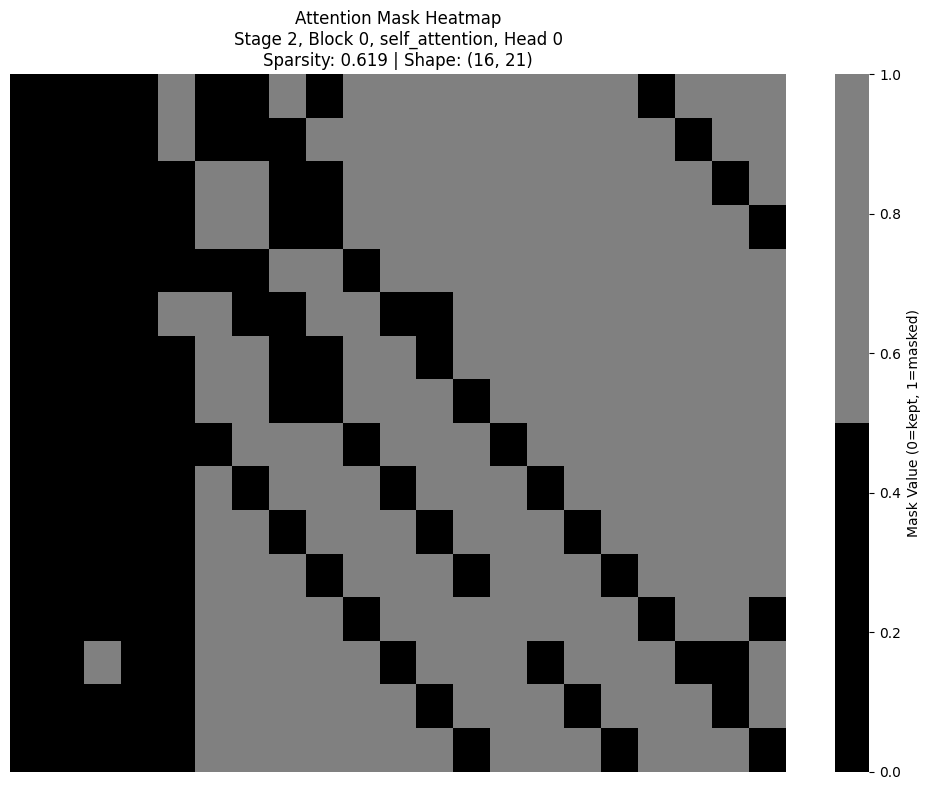

Mask热力图已保存到: ./sparsity_analysis/stage_2_block_0_heatmap.png
保存图像到: ./sparsity_analysis/stage_3_block_0_head_sparsity.png


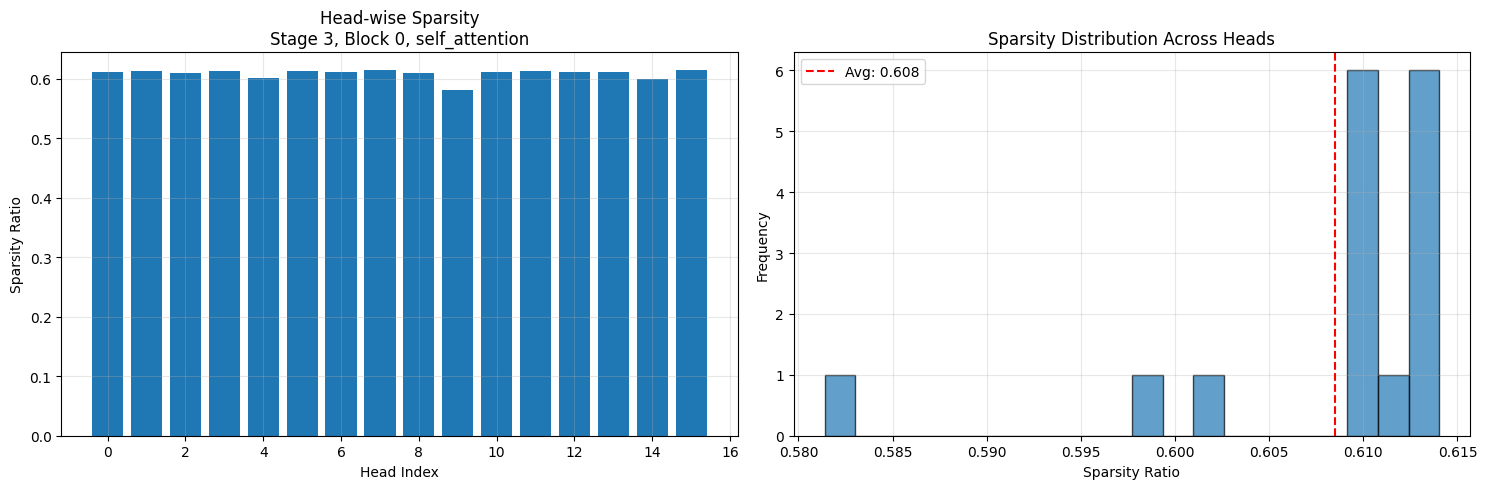

Head-wise稀疏度分析图已保存到: ./sparsity_analysis/stage_3_block_0_head_sparsity.png
保存热力图到: ./sparsity_analysis/stage_3_block_0_heatmap.png


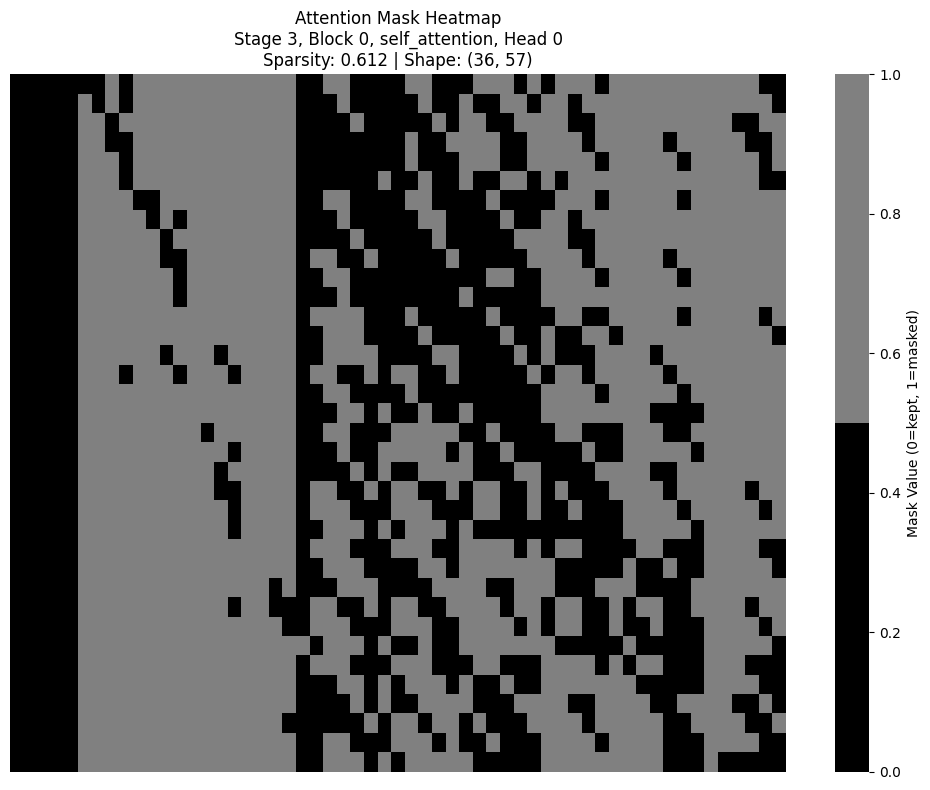

Mask热力图已保存到: ./sparsity_analysis/stage_3_block_0_heatmap.png
保存图像到: ./sparsity_analysis/stage_4_block_0_head_sparsity.png


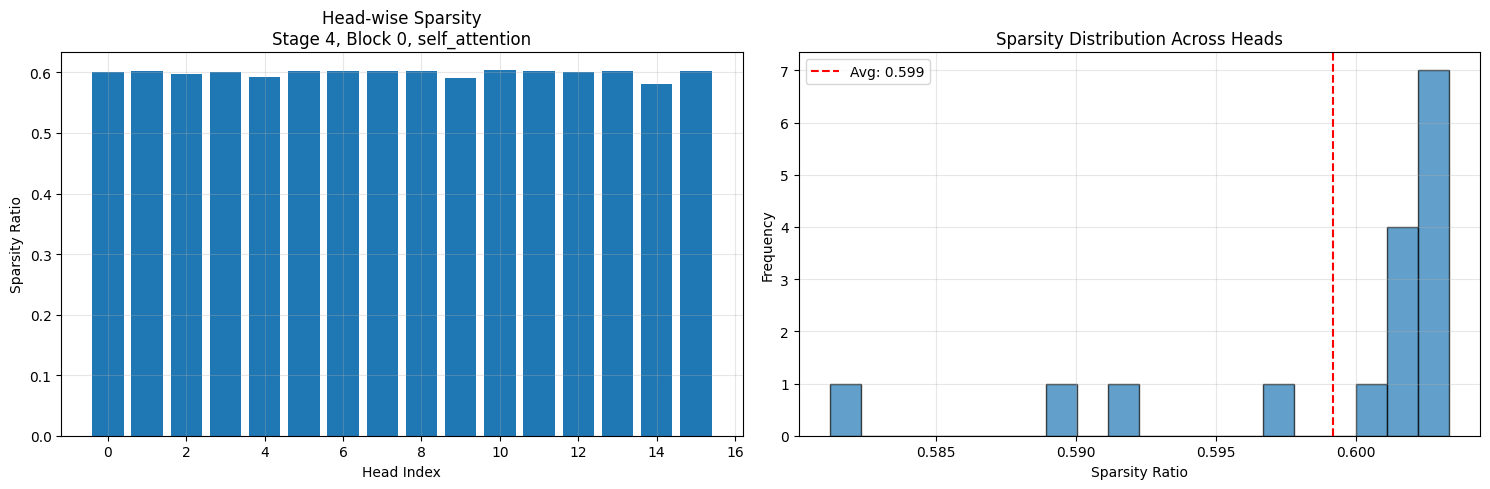

Head-wise稀疏度分析图已保存到: ./sparsity_analysis/stage_4_block_0_head_sparsity.png
保存热力图到: ./sparsity_analysis/stage_4_block_0_heatmap.png


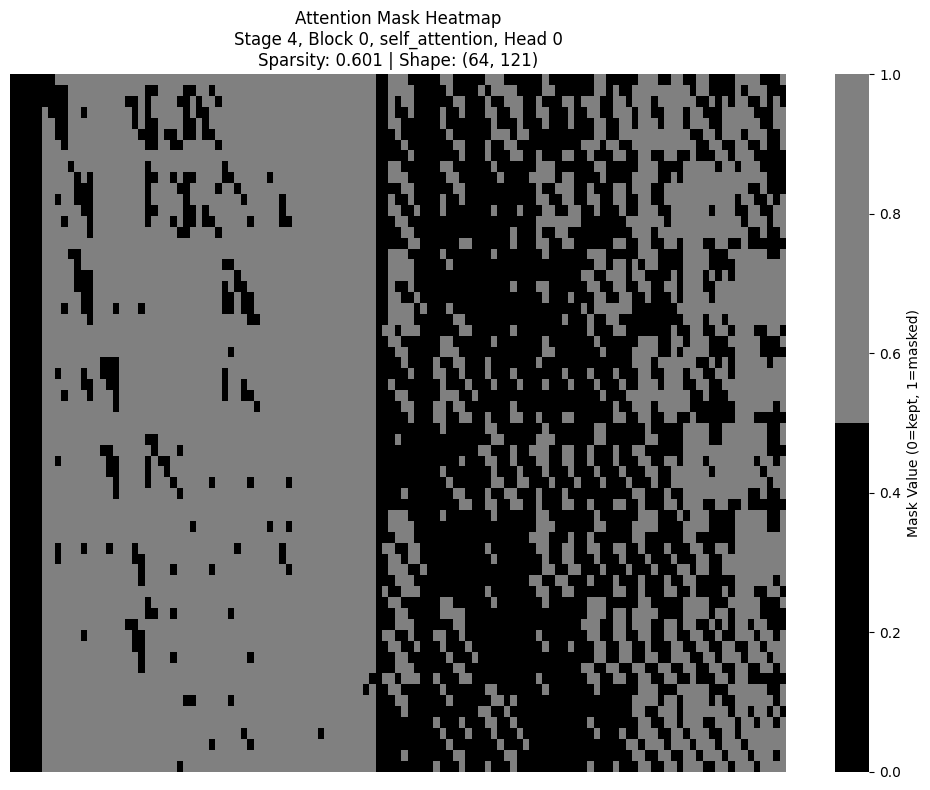

Mask热力图已保存到: ./sparsity_analysis/stage_4_block_0_heatmap.png
保存图像到: ./sparsity_analysis/stage_5_block_0_head_sparsity.png


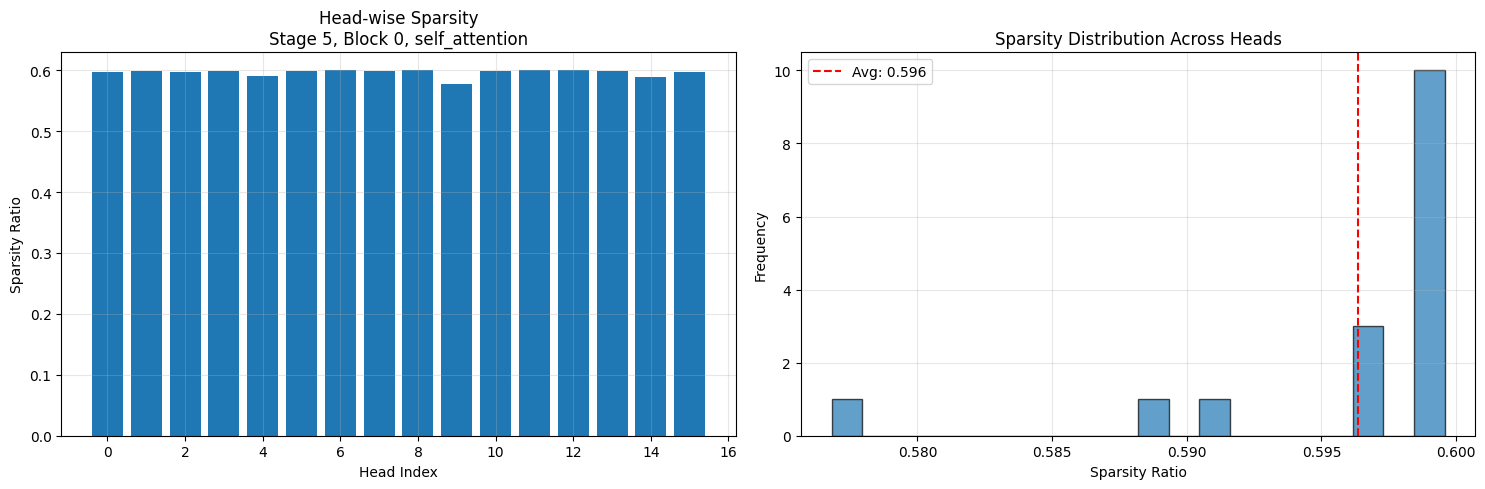

Head-wise稀疏度分析图已保存到: ./sparsity_analysis/stage_5_block_0_head_sparsity.png
保存热力图到: ./sparsity_analysis/stage_5_block_0_heatmap.png


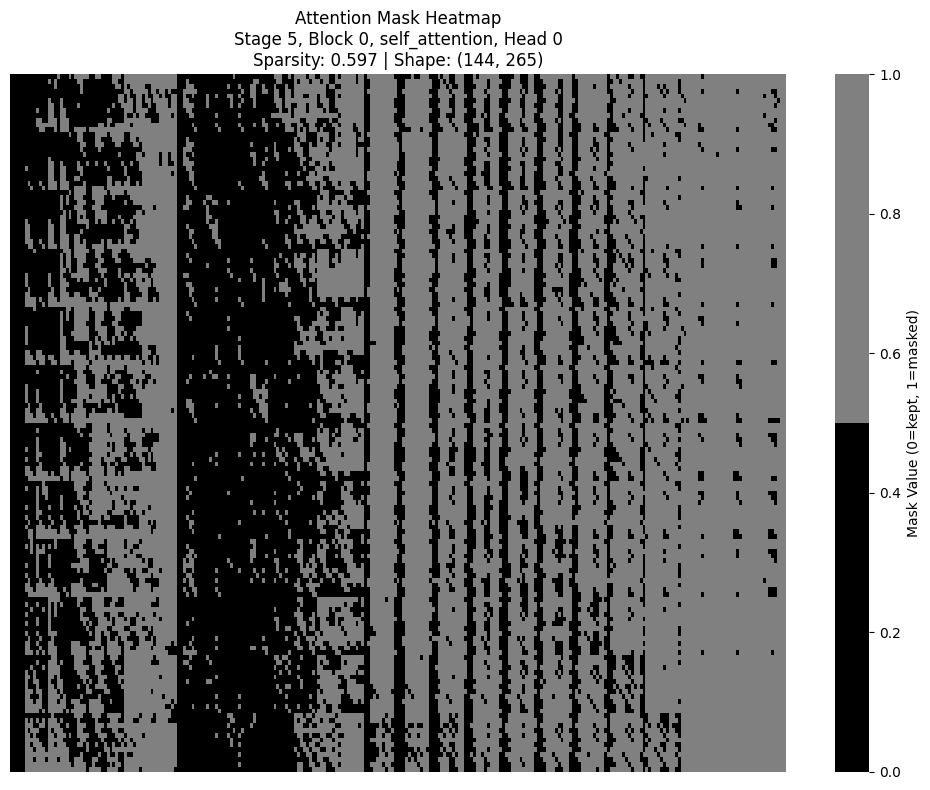

Mask热力图已保存到: ./sparsity_analysis/stage_5_block_0_heatmap.png
保存图像到: ./sparsity_analysis/stage_6_block_0_head_sparsity.png


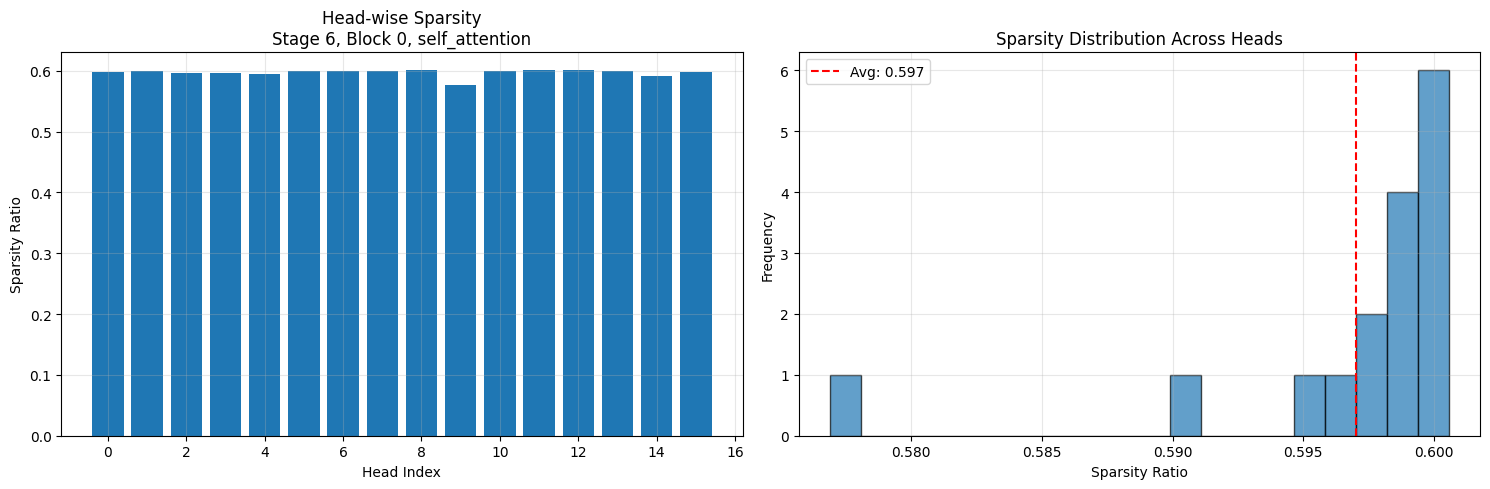

Head-wise稀疏度分析图已保存到: ./sparsity_analysis/stage_6_block_0_head_sparsity.png
保存热力图到: ./sparsity_analysis/stage_6_block_0_heatmap.png


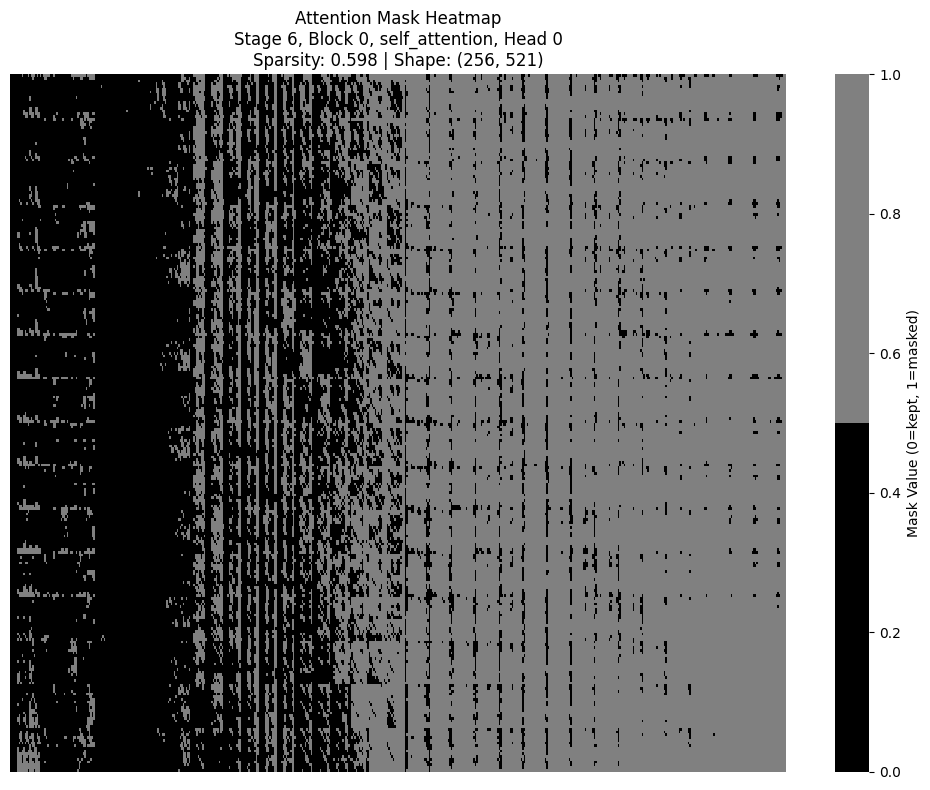

Mask热力图已保存到: ./sparsity_analysis/stage_6_block_0_heatmap.png
保存图像到: ./sparsity_analysis/stage_7_block_0_head_sparsity.png


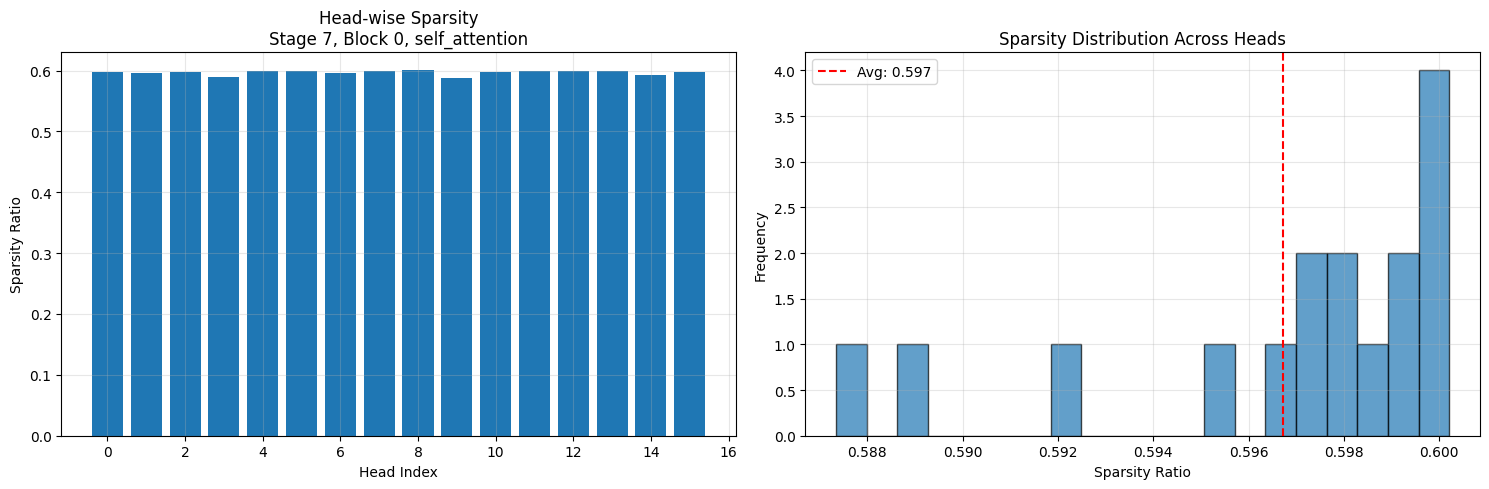

Head-wise稀疏度分析图已保存到: ./sparsity_analysis/stage_7_block_0_head_sparsity.png
保存热力图到: ./sparsity_analysis/stage_7_block_0_heatmap.png


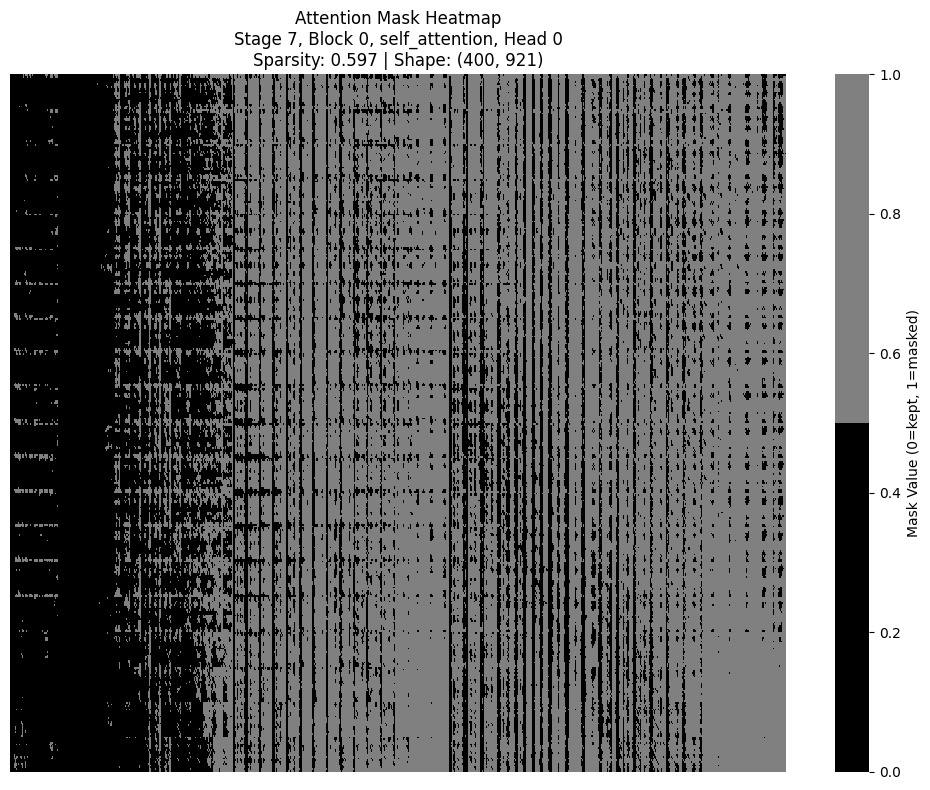

Mask热力图已保存到: ./sparsity_analysis/stage_7_block_0_heatmap.png

4. 统计摘要
----------------------------------------
分析摘要已保存到: ./sparsity_analysis/analysis_summary.txt

完整分析报告已生成到目录: ./sparsity_analysis


In [6]:
from mask_analyzer import *
analyzer = SparsityMaskAnalyzer("./sparsity_masks/mask_data.pkl")
analyzer.generate_comprehensive_report()

In [3]:
prompt = """A beautiful Chinese woman with graceful features, close-up portrait, long flowing black hair, wearing a traditional silk cheongsam delicately embroidered with floral patterns, face softly illuminated by ambient light, serene expression"""
cfg = 3
tau = 0.5
h_div_w = 1/1 # aspect ratio, height:width
seed = random.randint(0, 10000)
enable_positive_prompt=0

h_div_w_template_ = h_div_w_templates[np.argmin(np.abs(h_div_w_templates-h_div_w))]
scale_schedule = dynamic_resolution_h_w[h_div_w_template_][args.pn]['scales']
scale_schedule = [(1, h, w) for (_, h, w) in scale_schedule]
generated_image = gen_one_img_with_time(
    infinity,
    vae,
    text_tokenizer,
    text_encoder,
    prompt,
    './latency.xlsx',
    g_seed=seed,
    gt_leak=0,
    gt_ls_Bl=None,
    cfg_list=cfg,
    tau_list=tau,
    scale_schedule=scale_schedule,
    cfg_insertion_layer=[args.cfg_insertion_layer],
    vae_type=args.vae_type,
    sampling_per_bits=args.sampling_per_bits,
    enable_positive_prompt=enable_positive_prompt,
)
args.save_file = 'ipynb_tmp.jpg'
os.makedirs(osp.dirname(osp.abspath(args.save_file)), exist_ok=True)
cv2.imwrite(args.save_file, generated_image.cpu().numpy())
print(f'Save to {osp.abspath(args.save_file)}')

prompt=A beautiful Chinese woman with graceful features, close-up portrait, long flowing black hair, wearing a traditional silk cheongsam delicately embroidered with floral patterns, face softly illuminated by ambient light, serene expression
cfg: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], tau: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
cost: 1031.554s, infinity cost=1031.045s
Save to /DISK1/home/rh_xu30/Infinity/tools/ipynb_tmp.jpg


In [3]:
from run_infinity import gen_one_img_with_attnmap

prompt = """A beautiful Chinese woman with graceful features, close-up portrait, long flowing black hair, wearing a traditional silk cheongsam delicately embroidered with floral patterns, face softly illuminated by ambient light, serene expression"""
cfg = 3
tau = 0.5
h_div_w = 1/1 # aspect ratio, height:width
seed = random.randint(0, 10000)
enable_positive_prompt=0

h_div_w_template_ = h_div_w_templates[np.argmin(np.abs(h_div_w_templates-h_div_w))]
scale_schedule = dynamic_resolution_h_w[h_div_w_template_][args.pn]['scales']
scale_schedule = [(1, h, w) for (_, h, w) in scale_schedule]
generated_image, ana = gen_one_img_with_attnmap(
    infinity,
    vae,
    text_tokenizer,
    text_encoder,
    prompt,
    g_seed=seed,
    gt_leak=0,
    gt_ls_Bl=None,
    cfg_list=cfg,
    tau_list=tau,
    scale_schedule=scale_schedule,
    cfg_insertion_layer=[args.cfg_insertion_layer],
    vae_type=args.vae_type,
    sampling_per_bits=args.sampling_per_bits,
    enable_positive_prompt=enable_positive_prompt,
)
args.save_file = 'ipynb_tmp.jpg'
os.makedirs(osp.dirname(osp.abspath(args.save_file)), exist_ok=True)
cv2.imwrite(args.save_file, generated_image.cpu().numpy())
print(f'Save to {osp.abspath(args.save_file)}')
print(ana)

prompt=A beautiful Chinese woman with graceful features, close-up portrait, long flowing black hair, wearing a traditional silk cheongsam delicately embroidered with floral patterns, face softly illuminated by ambient light, serene expression
cfg: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], tau: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[INFO] Attention map collection enabled


/DISK1/home/rh_xu30/Infinity/tools/run_infinity.py:359: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16, cache_enabled=True):


[INFO] Collected attention maps for 160 stages
cost: 173.58479356765747, infinity cost=172.87549710273743
Save directory created/checked: ./attention_analysis
Analyzing stage_1_block_0...
Analyzing stage_1_block_1...
Analyzing stage_1_block_2...
Analyzing stage_1_block_3...
Analyzing stage_1_block_4...
Analyzing stage_1_block_5...
Analyzing stage_1_block_6...
Analyzing stage_1_block_7...
Analyzing stage_1_block_8...
Analyzing stage_1_block_9...
Analyzing stage_1_block_10...
Analyzing stage_1_block_11...
Analyzing stage_1_block_12...
Analyzing stage_1_block_13...
Analyzing stage_1_block_14...
Analyzing stage_1_block_15...
Analyzing stage_1_block_16...
Analyzing stage_1_block_17...
Analyzing stage_1_block_18...
Analyzing stage_1_block_19...
Analyzing stage_1_block_20...
Analyzing stage_1_block_21...
Analyzing stage_1_block_22...
Analyzing stage_1_block_23...
Analyzing stage_1_block_24...
Analyzing stage_1_block_25...
Analyzing stage_1_block_26...
Analyzing stage_1_block_27...
Analyzing s